In [2]:
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

cm = 1/2.54

In [3]:
# set matplotlib size
def mpl_figsize(scale_factor: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor, 4.8 * scale_factor

def mpl_figsize_xy(scale_factor_x: int | float, scale_factor_y: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor_x, 4.8 * scale_factor_y


In [4]:
def group_bottom_percent(labels, sizes, threshold):
    total = sum(sizes)
    labels_filtered = []
    sizes_filtered = []
    count = 0
    other_count = 0
    for label, size in zip(labels, sizes):
        if size / total < threshold:
            count += 1
            other_count += size
        else:
            labels_filtered.append(label)
            sizes_filtered.append(size)
    labels_filtered.append(f'other ({count})')
    sizes_filtered.append(other_count)
    return labels_filtered, sizes_filtered

In [5]:
# setup connection
conn = psycopg2.connect(
    host='localhost',
    database='cadets_e3',
    user='rosendahl',
)
conn.set_session(readonly=True)
# get cursor
cursor_benign = conn.cursor()
cursor_unknown = conn.cursor()

In [32]:
# close db resources
cursor_benign.close()
cursor_unknown.close()
conn.close()

In [5]:
# debug
os.system("hostnamectl hostname")
print(f'current working directory: {os.getcwd()}')

vmrosendahl
current working directory: /home/rosendahl/remote_interpreter/dataset/jupyter


In [6]:
# see ground truth 3.1 20180406 1100 CADETS – Nginx Backdoor w/ Drakon In-Memory
benign_end = '2018-04-06 11:00:00'

In [7]:
# stats

# no of events
query_b = f'''
select count(*)
from event e
where e.ts < '{benign_end}';
'''
query_u = f'''
select count(*)
from event e
where e.ts >= '{benign_end}';
'''

cursor_benign.execute(query_b)
cursor_unknown.execute(query_u)

event_count_b = cursor_benign.fetchone()[0]
event_count_u = cursor_unknown.fetchone()[0]

print(f'benign events: {event_count_b}')
print(f'unknown events: {event_count_u}')

# no of subjects
query_b = f'''
select count(distinct subject_uuid)
from event e
where e.ts < '{benign_end}';
'''
query_u = f'''
select count(distinct subject_uuid)
from event e
where e.ts >= '{benign_end}';
'''

cursor_benign.execute(query_b)
cursor_unknown.execute(query_u)

subject_count_b = cursor_benign.fetchone()[0]
subject_count_u = cursor_unknown.fetchone()[0]

print(f'benign subjects: {subject_count_b}')
print(f'unknown subjects: {subject_count_u}')

# total no of subjects
query = '''
select count(distinct subject_uuid)
from event e;
'''

cursor_benign.execute(query)
total_subject_count = cursor_benign.fetchone()[0]

print(f'total subjects: {total_subject_count}')
print(f'benign subjects: {subject_count_b / total_subject_count * 100:.2f}%')
print(f'unknown subjects: {subject_count_u / total_subject_count * 100:.2f}%')
print(f'subjects in both sets: {subject_count_b + subject_count_u - total_subject_count}, {(subject_count_b + subject_count_u) / total_subject_count * 100 - 100:.2f}%')

benign events: 11859796
unknown events: 29491099
benign subjects: 67611
unknown subjects: 156562
total subjects: 224146
benign subjects: 30.16%
unknown subjects: 69.85%
subjects in both sets: 27, 0.01%


In [9]:
# executable distribution
query_b = f'''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count 
from event e 
where e.ts < '{benign_end}'
group by e.properties_map_exec;
'''
query_u = f'''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count
from event e
where e.ts >= '{benign_end}'
group by e.properties_map_exec;
'''

cursor_benign.execute(query_b)
cursor_unknown.execute(query_u)

executables_b = cursor_benign.fetchall()
executables_b = dict(executables_b)

executables_u = cursor_unknown.fetchall()
executables_u = dict(executables_u)

executables_b = {k: v for k, v in sorted(executables_b.items(), key=lambda item: item[1], reverse=True)}
executables_u = {k: v for k, v in sorted(executables_u.items(), key=lambda item: item[1], reverse=True)}

executables_b = group_bottom_percent(list(executables_b.keys()), list(executables_b.values()), 0.01)
executables_u = group_bottom_percent(list(executables_u.keys()), list(executables_u.values()), 0.01)

# collect all executables (that dont fall into 'other' category)
executables = set([ e for e in executables_b[0] if not e.startswith('other') ] + [ e for e in executables_u[0] if not e.startswith('other') ])

['lsof', 'python2.7', 'find', 'imapd', 'vmstat', 'top', 'pkg', 'local', 'smtpd', 'sleep', 'bash', 'sshd', 'sh', 'trivial-rewrite', 'master', 'alpine', 'proxymap', 'cleanup', 'anvil', 'date']


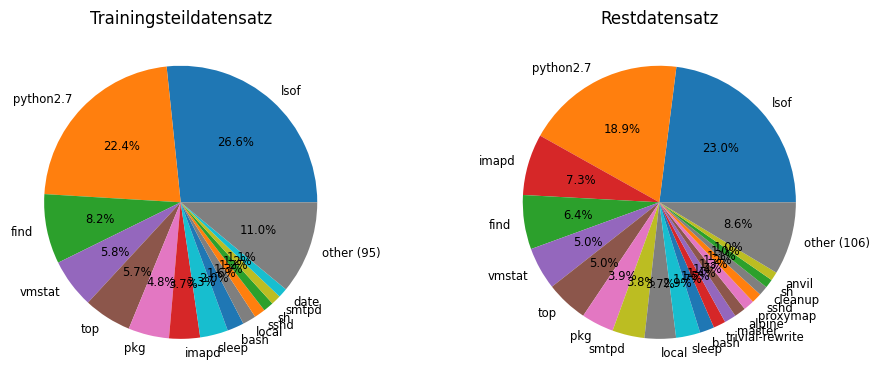

In [41]:
# get tab20 colors
tab20 = mcolors.TABLEAU_COLORS
colors = list(tab20.values())

executables_ordered = {}
for i in range(len(executables_b[0])):
    executables_ordered[executables_b[0][i]] = executables_b[1][i]
for i in range(len(executables_u[0])):
    if executables_u[0][i] in executables_ordered:
        executables_ordered[executables_u[0][i]] += executables_u[1][i]
    else:
        executables_ordered[executables_u[0][i]] = executables_u[1][i]


executables_ordered = list(executables_ordered.items())
# sort by count
executables_ordered = sorted(executables_ordered, key=lambda item: item[1], reverse=True)
# keep only names
executables_ordered = [ e[0] for e in executables_ordered ]
executables_ordered = [ e for e in executables_ordered if not e.startswith('other') ]
print(executables_ordered)

def get_color(executable):
    if executable in executables:
        return colors[executables_ordered.index(executable) % len(colors)]
    else:
        return 'gray'


# plot 2 pie charts, one above the other, aim for a4 size
# 10 cm width, 15 cm height
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.2)

# plot benign
ax[0].pie(executables_b[1], labels=executables_b[0], autopct='%1.1f%%', colors=[get_color(e) for e in executables_b[0]], textprops={'size': 'small'})
ax[0].set_title('Trainingsteildatensatz')
# plot unknown
ax[1].pie(executables_u[1], labels=executables_u[0], autopct='%1.1f%%', colors=[get_color(e) for e in executables_u[0]], textprops={'size': 'small'})
ax[1].set_title('Restdatensatz')

fig.set_size_inches((25 * cm, 10 * cm))
# Adjust layout to minimize padding
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
# Use tight_layout to further minimize padding
fig.tight_layout()
# save as svg
plt.savefig('figures/executable_events_distribution_vs.svg', bbox_inches='tight')

plt.show()

In [34]:
# class distribution
query_b = f'''
select distinct s.executable, count(s.executable) as count
from sequence s
where s.ts_end < '{benign_end}'
group by s.executable;   
'''

query_u = f'''
select distinct s.executable, count(s.executable) as count
from sequence s
where s.ts_end >= '{benign_end}'
group by s.executable;
'''

cursor_benign.execute(query_b)
cursor_unknown.execute(query_u)

classes_b = cursor_benign.fetchall()
classes_b = dict(classes_b)

classes_u = cursor_unknown.fetchall()
classes_u = dict(classes_u)

classes_b = {k: v for k, v in sorted(classes_b.items(), key=lambda item: item[1], reverse=True)}
classes_u = {k: v for k, v in sorted(classes_u.items(), key=lambda item: item[1], reverse=True)}

classes_b = group_bottom_percent(list(classes_b.keys()), list(classes_b.values()), 0.01)
classes_u = group_bottom_percent(list(classes_u.keys()), list(classes_u.values()), 0.01)

# collect all executables (that dont fall into 'other' category)
classes = set([ e for e in classes_b[0] if not e.startswith('other') ] + [ e for e in classes_u[0] if not e.startswith('other') ])

['bash', 'sleep', 'vmstat', 'sh', 'imapd', 'top', 'date', 'lsof', 'head', 'mv', 'cron', 'master', 'mlock', 'sshd', 'inetd']


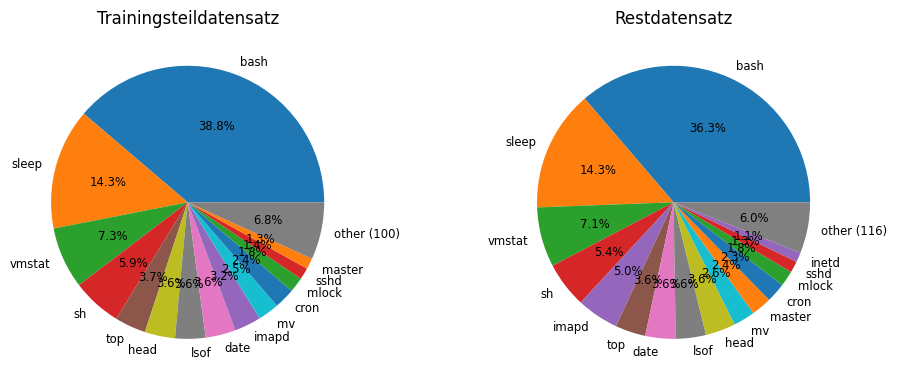

In [40]:
# plot

classes_ordered = {}
for i in range(len(classes_b[0])):
    classes_ordered[classes_b[0][i]] = classes_b[1][i]
for i in range(len(classes_u[0])):
    if classes_u[0][i] in classes_ordered:
        classes_ordered[classes_u[0][i]] += classes_u[1][i]
    else:
        classes_ordered[classes_u[0][i]] = classes_u[1][i]
        
classes_ordered = list(classes_ordered.items())
# sort by count
classes_ordered = sorted(classes_ordered, key=lambda item: item[1], reverse=True)
# keep only names
classes_ordered = [ e[0] for e in classes_ordered ]
classes_ordered = [ e for e in classes_ordered if not e.startswith('other') ]
print(classes_ordered)

def get_color(executable):
    if executable in classes:
        return colors[classes_ordered.index(executable) % len(colors)]
    else:
        return 'gray'

# plot 2 pie charts, one above the other, aim for a4 size
# 10 cm width, 15 cm height
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.2)

# plot benign
ax[0].pie(classes_b[1], labels=classes_b[0], autopct='%1.1f%%', colors=[get_color(e) for e in classes_b[0]], textprops={'size': 'small'})
ax[0].set_title('Trainingsteildatensatz')
# plot unknown
ax[1].pie(classes_u[1], labels=classes_u[0], autopct='%1.1f%%', colors=[get_color(e) for e in classes_u[0]], textprops={'size': 'small'})
ax[1].set_title('Restdatensatz')


fig.set_size_inches((25 * cm, 10 * cm))
# Adjust layout to minimize padding
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
# Use tight_layout to further minimize padding
fig.tight_layout()

# save as svg
plt.savefig('figures/class_distribution_vs.svg', bbox_inches='tight')

plt.show()

In [47]:
# sequence length distribution separated

query_b = f'''
select s.executable, percentile_cont(0.5) within group (order by length) as median_len
from sequence s
where s.ts_end < '{benign_end}'
group by s.executable;
'''

query_u = f'''
select s.executable, percentile_cont(0.5) within group (order by s.length) as median_len
from sequence s
where s.ts_end >= '{benign_end}'
group by s.executable;
'''

cursor_benign.execute(query_b)
cursor_unknown.execute(query_u)

lengths_b = cursor_benign.fetchall()
lengths_b = dict(lengths_b)

lengths_u = cursor_unknown.fetchall()
lengths_u = dict(lengths_u)

lengths_b = {k: v for k, v in sorted(lengths_b.items(), key=lambda item: item[1], reverse=True)}
lengths_u = {k: v for k, v in sorted(lengths_u.items(), key=lambda item: item[1], reverse=True)}

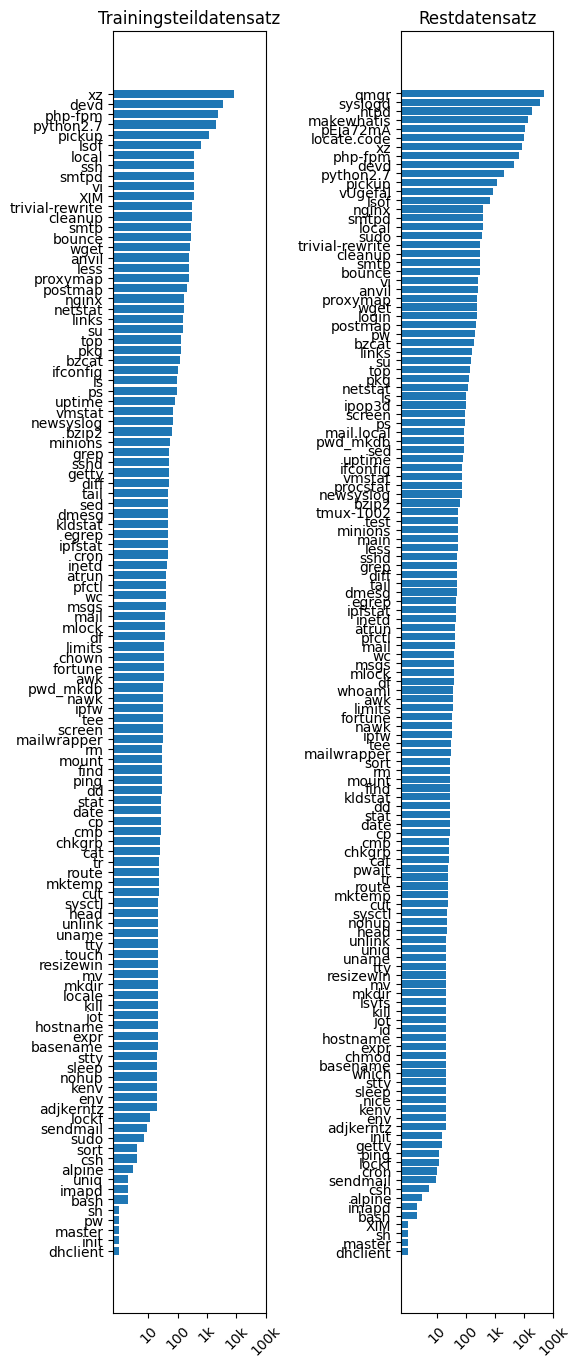

In [73]:
# plot 2 bar charts, one above the other, aim for a4 width

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.2)

# reverse order
lengths_b_rev = dict(sorted(lengths_b.items(), key=lambda item: item[1]))
lengths_u_rev = dict(sorted(lengths_u.items(), key=lambda item: item[1]))

# plot the executables on the y-axis and the median sequence length on the x-axis
# plot benign
ax[0].barh(list(lengths_b_rev.keys()), list(lengths_b_rev.values()))
ax[0].set_title('Trainingsteildatensatz')

# plot unknown
ax[1].barh(list(lengths_u_rev.keys()), list(lengths_u_rev.values()))
ax[1].set_title('Restdatensatz')

# set x axis log
ax[0].set_xscale('log')
ax[1].set_xscale('log')
# set x axis ticks
ax[0].set_xticks([10, 100, 1000, 10000, 100000])
ax[1].set_xticks([10, 100, 1000, 10000, 100000])
# set x axis labels
ax[0].set_xticklabels(['10', '100', '1k', '10k', '100k'])
ax[1].set_xticklabels(['10', '100', '1k', '10k', '100k'])
# rotate x axis labels
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)


fig.set_size_inches((15 * cm, 35 * cm))
# Adjust layout to minimize padding
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
# Use tight_layout to further minimize padding
fig.tight_layout()

# save as svg
plt.savefig('figures/sequence_length_distribution_vs.svg', bbox_inches='tight')

plt.show()

In [74]:
# sequence length distribution unified
query = f'''
select s.executable, percentile_cont(0.5) within group (order by s.length) as median_len
from sequence s
group by s.executable;
'''

cursor_benign.execute(query)

lengths = cursor_benign.fetchall()
lengths = dict(lengths)

lengths = {k: v for k, v in sorted(lengths.items(), key=lambda item: item[1], reverse=True)}

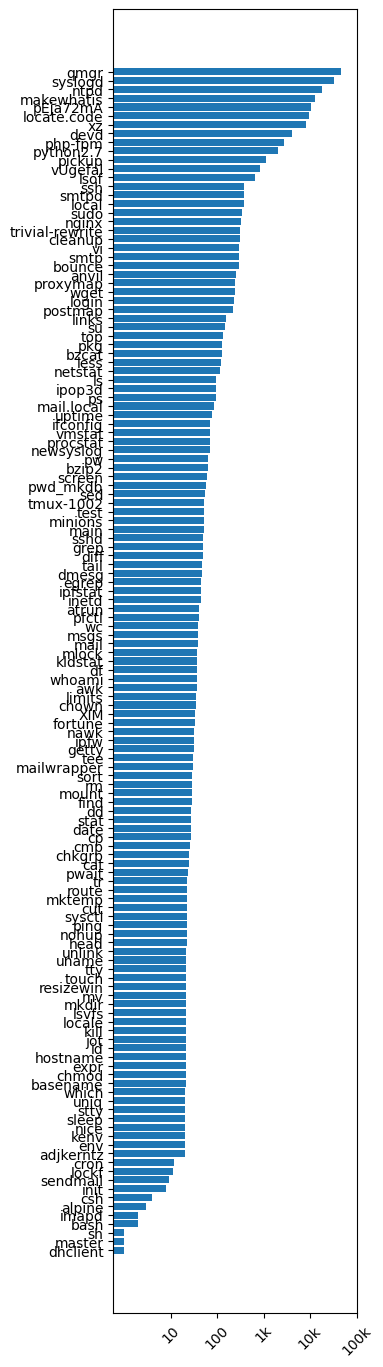

In [78]:
# plot bar chart

# reverse order
lengths_rev = dict(sorted(lengths.items(), key=lambda item: item[1]))

# plot the executables on the y-axis and the median sequence length on the x-axis
fig, ax = plt.subplots()
ax.barh(list(lengths_rev.keys()), list(lengths_rev.values()))

# set x axis log
ax.set_xscale('log')
# set x axis ticks
ax.set_xticks([10, 100, 1000, 10000, 100000])
# set x axis labels
ax.set_xticklabels(['10', '100', '1k', '10k', '100k'])
# rotate x axis labels
ax.tick_params(axis='x', rotation=45)

fig.set_size_inches((10 * cm, 35 * cm))
# Adjust layout to minimize padding
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
# Use tight_layout to further minimize padding
fig.tight_layout()

# save as svg
plt.savefig('figures/sequence_length_distribution_unified.svg', bbox_inches='tight')

plt.show()

In [18]:
# get top 33% of executables
query = f'''
select s.executable, count(s.executable) as count
from sequence s
group by s.executable;
'''

cursor_benign.execute(query)

executables = cursor_benign.fetchall()
executables = dict(executables)

executables = {k: v for k, v in sorted(executables.items(), key=lambda item: item[1], reverse=True)}

# get sum of all counts
total = sum(executables.values())
top = total * (1 - 0.99)
print(top)
executables = {k: v for k, v in executables.items() if v > top}


print(executables)
print(len(executables))

4318.9500000000035
{'bash': 159934, 'sleep': 61840, 'vmstat': 30877, 'sh': 24042, 'imapd': 19082, 'top': 15618, 'date': 15469, 'lsof': 15452, 'head': 15441, 'mv': 10940, 'cron': 10169, 'master': 8898, 'mlock': 7817, 'sshd': 5855, 'inetd': 4324}
15


In [124]:
print('sh' in executables)

True


total number of executables: 135
67
68


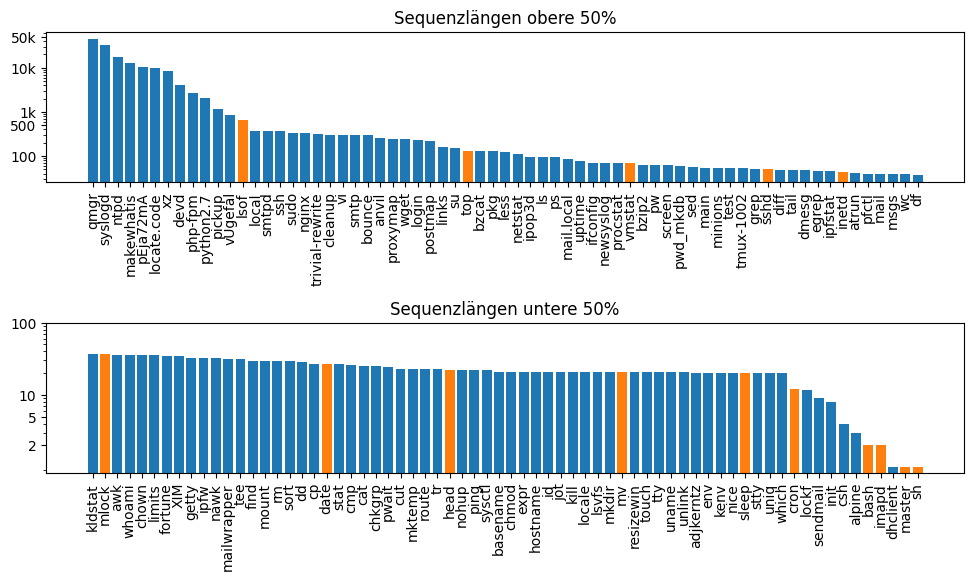

In [130]:
# sequence length distribution unified horizontal, split into 2 parts, second below the first
# split into 2 parts
lengths_1 = {k: v for k, v in list(lengths.items())[:len(lengths) // 2]}
lengths_2 = {k: v for k, v in list(lengths.items())[len(lengths) // 2:]}

# print total number of executables
print(f'total number of executables: {len(lengths)}')
print(len(lengths_1))
print(len(lengths_2))

# bar chart
fig, ax = plt.subplots(2)
fig.subplots_adjust(hspace=0.2)

# executables on x axis, median sequence length on y axis
# plot first half
ax[0].bar(list(lengths_1.keys()), list(lengths_1.values()), color=['tab:orange' if e in executables else 'tab:blue' for e in lengths_1.keys()])
ax[0].set_title('Sequenzlängen obere 50%')

# plot second half
ax[1].bar(list(lengths_2.keys()), list(lengths_2.values()), color=['tab:orange' if e in executables else 'tab:blue' for e in lengths_2.keys()])
ax[1].set_title('Sequenzlängen untere 50%')

# set y axis log
ax[0].set_yscale('log')
ax[1].set_yscale('log')
# set y axis ticks
ax[0].set_yticks([100, 500, 1000, 10000, 50000])
ax[1].set_yticks([2, 5, 10, 100])
# set y axis labels
ax[0].set_yticklabels(['100', '500', '1k', '10k', '50k'])
ax[1].set_yticklabels(['2', '5', '10', '100'])

# rotate x labels
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)

# grid
#ax[0].grid(axis='y')
#ax[1].grid(axis='y')
# grid opacity
#ax[0].grid(alpha=0.5)
#ax[1].grid(alpha=0.5)

fig.set_size_inches((25 * cm, 15 * cm))
# Adjust layout to minimize padding
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
# Use tight_layout to further minimize padding
fig.tight_layout()

# save as svg
plt.savefig('figures/sequence_length_distribution_unified_split.svg', bbox_inches='tight')

plt.show()

In [14]:
# generate a scatter plot on one axis. axis should visualize sequence length, blob size should executable count

# get sequence length and count
query = f'''
select s.executable, percentile_cont(0.5) within group (order by s.length) as median_len, count(s.executable) as count
from sequence s
group by s.executable;
'''

cursor_benign.execute(query)

lengths = cursor_benign.fetchall()

In [15]:
print(lengths)

[('adjkerntz', 20.0, 132), ('alpine', 3.0, 1073), ('anvil', 251.0, 899), ('atrun', 41.0, 3116), ('awk', 36.0, 57), ('basename', 21.0, 11), ('bash', 2.0, 159934), ('bounce', 292.0, 4), ('bzcat', 127.0, 13), ('bzip2', 63.0, 12), ('cat', 25.0, 331), ('chkgrp', 25.0, 11), ('chmod', 21.0, 1), ('chown', 35.0, 1), ('cleanup', 303.0, 1157), ('cmp', 26.0, 51), ('cp', 27.0, 388), ('cron', 12.0, 10169), ('csh', 4.0, 9), ('cut', 23.0, 2), ('date', 27.0, 15469), ('dd', 28.0, 1560), ('devd', 4140.0, 3), ('df', 37.0, 12), ('dhclient', 1.0, 104), ('diff', 49.0, 7), ('dmesg', 47.0, 187), ('egrep', 46.0, 33), ('env', 20.0, 15), ('expr', 21.0, 25), ('find', 29.0, 256), ('fortune', 34.0, 1166), ('getty', 32.0, 2), ('grep', 50.0, 59), ('head', 22.0, 15441), ('hostname', 21.0, 134), ('id', 21.0, 2), ('ifconfig', 71.0, 4), ('imapd', 2.0, 19082), ('inetd', 44.0, 4324), ('init', 8.0, 2), ('ipfstat', 45.0, 9), ('ipfw', 32.0, 6), ('ipop3d', 96.0, 3), ('jot', 21.0, 9), ('kenv', 20.0, 17), ('kill', 21.0, 12), ('kl

In [16]:
# sort by count
lengths = sorted(lengths, key=lambda item: item[2], reverse=True)
print(lengths)

[('bash', 2.0, 159934), ('sleep', 20.0, 61840), ('vmstat', 70.0, 30877), ('sh', 1.0, 24042), ('imapd', 2.0, 19082), ('top', 133.0, 15618), ('date', 27.0, 15469), ('lsof', 639.0, 15452), ('head', 22.0, 15441), ('mv', 21.0, 10940), ('cron', 12.0, 10169), ('master', 1.0, 8898), ('mlock', 37.0, 7817), ('sshd', 50.0, 5855), ('inetd', 44.0, 4324), ('atrun', 41.0, 3116), ('local', 371.0, 2630), ('smtpd', 371.0, 1691), ('sysctl', 22.0, 1567), ('dd', 28.0, 1560), ('unlink', 21.0, 1551), ('proxymap', 244.0, 1237), ('resizewin', 21.0, 1167), ('fortune', 34.0, 1166), ('cleanup', 303.0, 1157), ('trivial-rewrite', 308.0, 1153), ('alpine', 3.0, 1073), ('anvil', 251.0, 899), ('python2.7', 2071.0, 809), ('netstat', 113.0, 432), ('rm', 29.0, 432), ('cp', 27.0, 388), ('sendmail', 9.0, 332), ('cat', 25.0, 331), ('newsyslog', 70.0, 272), ('find', 29.0, 256), ('mkdir', 21.0, 239), ('wget', 243.0, 196), ('dmesg', 47.0, 187), ('uptime', 79.0, 184), ('pkg', 127.0, 170), ('pickup', 1133.0, 159), ('hostname', 21

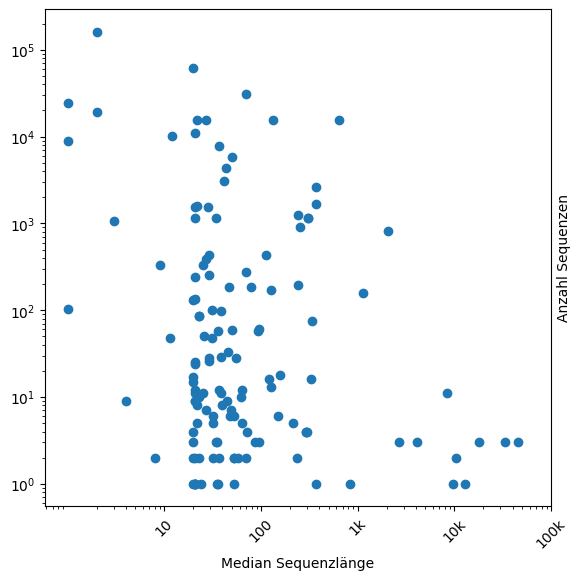

In [24]:
# plot 
fig, ax = plt.subplots()

# plot scatter
ax.scatter([l[1] for l in lengths], [l[2] for l in lengths])

# set y axis log
ax.set_yscale('log')
# set x axis log
ax.set_xscale('log')
# set x axis ticks
ax.set_xticks([10, 100, 1000, 10000, 100000])
# set x axis labels


# set x axis description
ax.set_xlabel('Median Sequenzlänge')
# set y axis description
ax.set_ylabel('Anzahl Sequenzen')
ax.yaxis.set_label_position('right')

ax.set_xticklabels(['10', '100', '1k', '10k', '100k'])
# rotate x axis labels
ax.tick_params(axis='x', rotation=45)

fig.set_size_inches((15 * cm, 15 * cm))
# Adjust layout to minimize padding
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
# Use tight_layout to further minimize padding
fig.tight_layout()

# save as svg
#plt.savefig('figures/sequence_length_vs_count.svg', bbox_inches='tight')

plt.show()

In [25]:
# get class distribution, calculate weighted and macro average for precision, recall and f1 for a random agent
query = '''
select s.executable, count(s.executable) as count
from sequence s
group by s.executable;
'''

cursor_benign.execute(query)

classes = cursor_benign.fetchall()
classes = dict(classes)
print(classes)

{'adjkerntz': 132, 'alpine': 1073, 'anvil': 899, 'atrun': 3116, 'awk': 57, 'basename': 11, 'bash': 159934, 'bounce': 4, 'bzcat': 13, 'bzip2': 12, 'cat': 331, 'chkgrp': 11, 'chmod': 1, 'chown': 1, 'cleanup': 1157, 'cmp': 51, 'cp': 388, 'cron': 10169, 'csh': 9, 'cut': 2, 'date': 15469, 'dd': 1560, 'devd': 3, 'df': 12, 'dhclient': 104, 'diff': 7, 'dmesg': 187, 'egrep': 33, 'env': 15, 'expr': 25, 'find': 256, 'fortune': 1166, 'getty': 2, 'grep': 59, 'head': 15441, 'hostname': 134, 'id': 2, 'ifconfig': 4, 'imapd': 19082, 'inetd': 4324, 'init': 2, 'ipfstat': 9, 'ipfw': 6, 'ipop3d': 3, 'jot': 9, 'kenv': 17, 'kill': 12, 'kldstat': 2, 'less': 16, 'limits': 3, 'links': 18, 'local': 2630, 'locale': 1, 'locate.code': 1, 'lockf': 48, 'login': 2, 'ls': 61, 'lsof': 15452, 'lsvfs': 1, 'mail': 29, 'mail.local': 3, 'mailwrapper': 48, 'main': 1, 'makewhatis': 1, 'master': 8898, 'minions': 2, 'mkdir': 239, 'mktemp': 85, 'mlock': 7817, 'mount': 26, 'msgs': 11, 'mv': 10940, 'nawk': 5, 'netstat': 432, 'newsy

In [27]:
# Calculate total number of occurrences
total_occurrences = sum(classes.values())

# Calculate class probabilities (p_i)
class_probabilities = {}
for class_name, count in classes.items():
    class_probabilities[class_name] = count / total_occurrences

# Initialize variables to store metrics
macro_precision = 0.0
macro_recall = 0.0
macro_f1 = 0.0
weighted_precision = 0.0
weighted_recall = 0.0
weighted_f1 = 0.0

# Iterate through class probabilities to calculate metrics
for class_name, p_i in class_probabilities.items():
    # For a random classifier, precision, recall, and F1-score are equal to p_i
    precision = p_i
    recall = p_i
    f1_score = p_i

    # Add to macro metrics (sum of all precisions, recalls, F1-scores)
    macro_precision += precision
    macro_recall += recall
    macro_f1 += f1_score

    # Add to weighted metrics (weighted by p_i)
    weighted_precision += p_i * precision
    weighted_recall += p_i * recall
    weighted_f1 += p_i * f1_score

# Calculate macro averages by dividing by the number of classes
num_classes = len(classes)
macro_precision /= num_classes
macro_recall /= num_classes
macro_f1 /= num_classes

# Output the calculated metrics
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

Macro Precision: 0.0074
Macro Recall: 0.0074
Macro F1-Score: 0.0074
Weighted Precision: 0.1754
Weighted Recall: 0.1754
Weighted F1-Score: 0.1754


In [29]:
# Calculate total number of occurrences
total_occurrences = sum(classes.values())

# Calculate class probabilities (p_i)
class_probabilities = {}
for class_name, count in classes.items():
    class_probabilities[class_name] = count / total_occurrences

# Initialize variables to store metrics
macro_precision = 0.0
macro_recall = 0.0
macro_f1 = 0.0
weighted_precision = 0.0
weighted_recall = 0.0
weighted_f1 = 0.0

# Iterate through class probabilities to calculate metrics
for class_name, p_i in class_probabilities.items():
    # Expected precision for a random agent with knowledge of distribution is still p_i
    precision = p_i
    recall = p_i
    f1_score = p_i

    # Add to macro metrics (sum of all precisions, recalls, F1-scores)
    macro_precision += precision
    macro_recall += recall
    macro_f1 += f1_score

    # Add to weighted metrics (weighted by true class distribution)
    weighted_precision += p_i * precision
    weighted_recall += p_i * recall
    weighted_f1 += p_i * f1_score

# Calculate macro averages by dividing by the number of classes
num_classes = len(classes)
macro_precision /= num_classes
macro_recall /= num_classes
macro_f1 /= num_classes

# Output the calculated metrics
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")


Macro Precision: 0.0074
Macro Recall: 0.0074
Macro F1-Score: 0.0074
Weighted Precision: 0.1754
Weighted Recall: 0.1754
Weighted F1-Score: 0.1754
